In [2]:
import os 

# Define the base directory for the dataset
base_path = "./water pump audio for anomaly detection/"  # Assumi che il dataset sia nella stessa directory del notebook

# Define paths to each specific subset of the dataset
anomaly_path = os.path.join(base_path, "anomaly")          # Path for anomalous audio files
train_normal_path = os.path.join(base_path, "train-normal") # Path for normal training audio files
test_normal_path = os.path.join(base_path, "test-normal")   # Path for normal testing audio files

# Function to count the number of `.wav` files in a directory
def count_files_in_directory(directory):
    """
    Counts the number of `.wav` files in a given directory.

    Args:
        directory (str): Path to the directory to analyze.

    Returns:
        int: Number of `.wav` files in the directory.
    """
    return len([file for file in os.listdir(directory) if file.endswith('.wav')])

# Count the number of files in each subset
anomaly_count = count_files_in_directory(anomaly_path)
train_normal_count = count_files_in_directory(train_normal_path)
test_normal_count = count_files_in_directory(test_normal_path)

# Print the analysis
print("Preliminary Dataset Analysis:")
print(f"Number of files in 'anomaly': {anomaly_count}")
print(f"Number of files in 'train-normal': {train_normal_count}")
print(f"Number of files in 'test-normal': {test_normal_count}")

Preliminary Dataset Analysis:
Number of files in 'anomaly': 456
Number of files in 'train-normal': 2241
Number of files in 'test-normal': 400


Preliminary Dataset Analysis:
Number of files in 'anomaly': 456
Number of files in 'train-normal': 2241
Number of files in 'test-normal': 400
Preprocessing audio files...
Anomaly Data Shape: (456, 431, 120)
Train Normal Data Shape: (2241, 431, 120)
Test Normal Data Shape: (400, 431, 120)
Visualizing an anomaly sample...


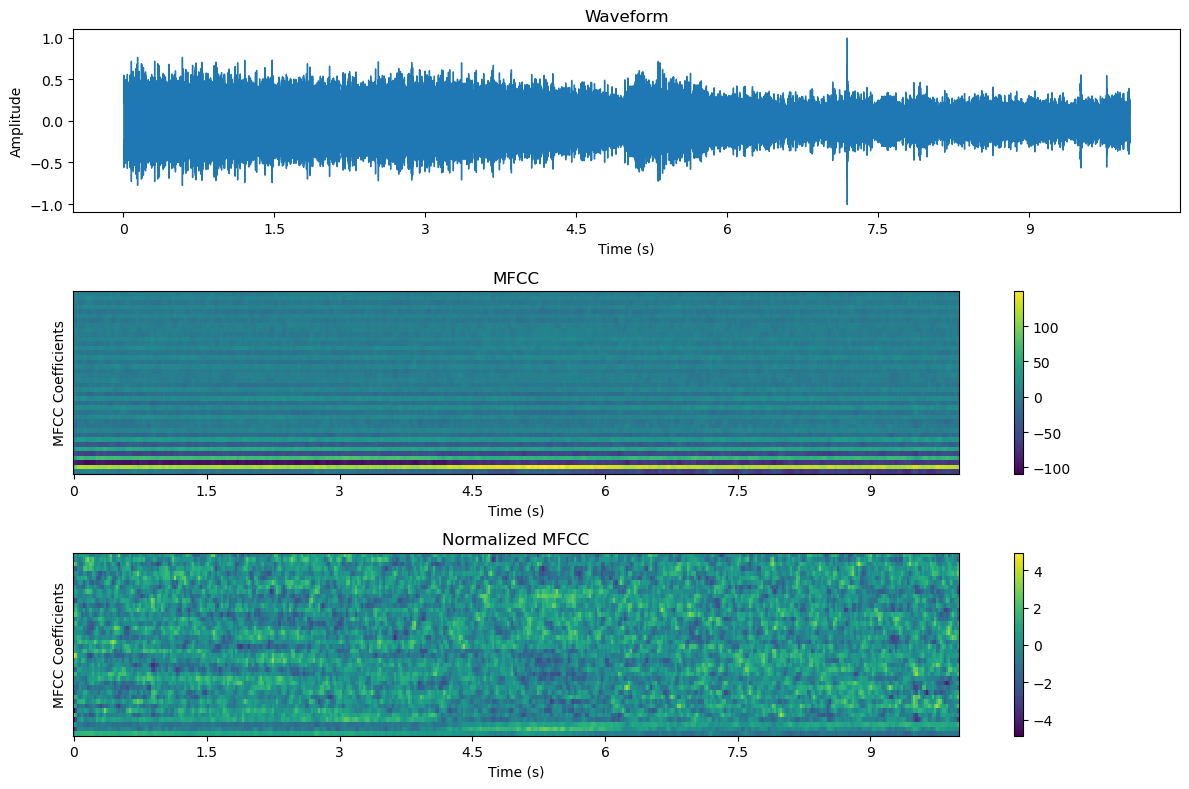

Visualizing a train-normal sample...


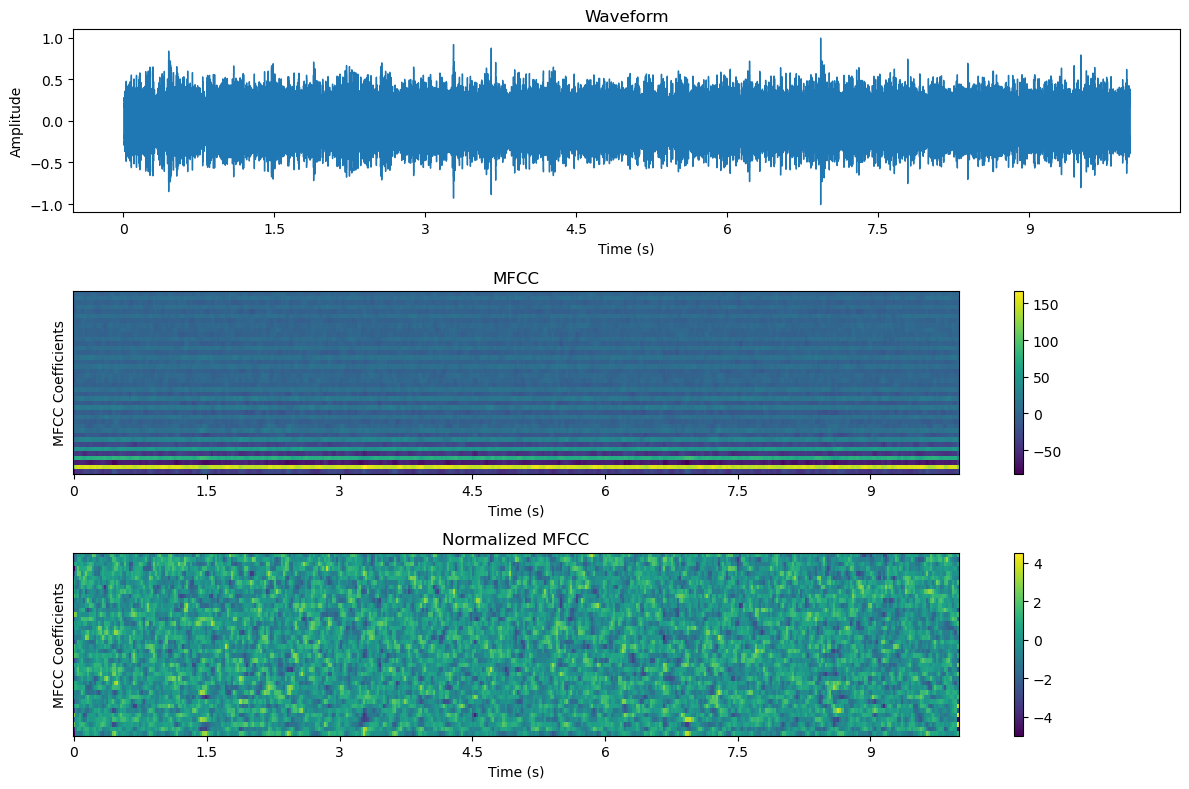

Visualizing a test-normal sample...


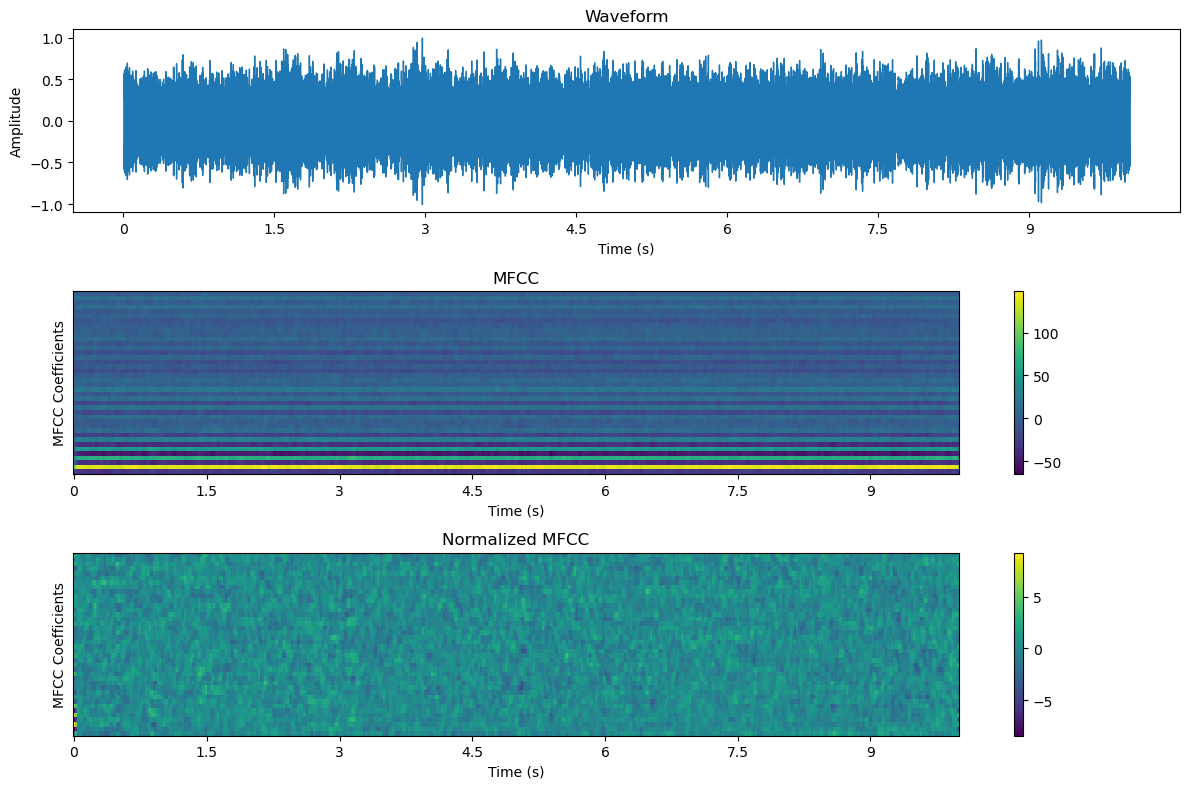

In [3]:
# TEST PHASE

import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt

# Define the base directory for the dataset
base_path = "./water pump audio for anomaly detection/"

# Define paths to each specific subset of the dataset
anomaly_path = os.path.join(base_path, "anomaly")          # Path for anomalous audio files
train_normal_path = os.path.join(base_path, "train-normal") # Path for normal training audio files
test_normal_path = os.path.join(base_path, "test-normal")   # Path for normal testing audio files

# Function to count the number of `.wav` files in a directory
def count_files_in_directory(directory):
    """
    Counts the number of `.wav` files in a given directory.

    Args:
        directory (str): Path to the directory to analyze.

    Returns:
        int: Number of `.wav` files in the directory.
    """
    return len([file for file in os.listdir(directory) if file.endswith('.wav')])

# Count the number of files in each subset
anomaly_count = count_files_in_directory(anomaly_path)
train_normal_count = count_files_in_directory(train_normal_path)
test_normal_count = count_files_in_directory(test_normal_path)

# Print the analysis
print("Preliminary Dataset Analysis:")
print(f"Number of files in 'anomaly': {anomaly_count}")
print(f"Number of files in 'train-normal': {train_normal_count}")
print(f"Number of files in 'test-normal': {test_normal_count}")

# Function to load and validate an audio file
def check_audio_file(file_path):
    """
    Checks if an audio file can be successfully loaded.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        bool: True if the file is valid, False otherwise.
    """
    try:
        librosa.load(file_path, sr=None)
        return True
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return False

# Function to normalize MFCC features using Z-score normalization
def normalize_mfcc(mfcc):
    """
    Standardizes MFCC features using Z-score normalization.

    Args:
        mfcc (np.ndarray): MFCC features.

    Returns:
        np.ndarray: Normalized MFCC features.
    """
    return (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / (np.std(mfcc, axis=1, keepdims=True) + 1e-8)

# Function to preprocess an audio file
def preprocess_audio(file_path, sr=22050, n_mfcc=40, max_duration=10):
    """
    Processes an audio file by loading, normalizing, padding, and extracting features.

    Args:
        file_path (str): Path to the audio file.
        sr (int): Sampling rate.
        n_mfcc (int): Number of MFCC features.
        max_duration (int): Duration in seconds.

    Returns:
        np.ndarray: Combined MFCC, delta, and delta-delta features.
    """
    signal, sr = librosa.load(file_path, sr=sr)
    signal = signal / np.max(np.abs(signal))

    # Ensure uniform length
    max_length = sr * max_duration
    if len(signal) < max_length:
        signal = np.pad(signal, (0, max_length - len(signal)), 'constant')
    else:
        signal = signal[:max_length]

    # Extract MFCC and additional features
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # Combine features
    combined_mfcc = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

    # Normalize features
    normalized_mfcc = normalize_mfcc(combined_mfcc)

    return normalized_mfcc.T

# Function to preprocess an entire directory of audio files
def preprocess_directory(valid_files, directory):
    """
    Preprocesses all valid audio files in a directory.

    Args:
        valid_files (list): List of valid audio file names.
        directory (str): Path to the directory containing the files.

    Returns:
        np.ndarray: Preprocessed audio features.
    """
    data = []
    for file in valid_files:
        file_path = os.path.join(directory, file)
        processed = preprocess_audio(file_path)
        data.append(processed)
    return np.array(data)

# Plot audio and feature extraction stages
def plot_audio_and_features(file_path, sr=22050, n_mfcc=40, max_duration=10):
    """
    Plots the waveform, MFCC, and normalized MFCC features of an audio file.

    Args:
        file_path (str): Path to the audio file.
        sr (int): Sampling rate.
        n_mfcc (int): Number of MFCC features.
        max_duration (int): Duration in seconds.
    """
    signal, sr = librosa.load(file_path, sr=sr)
    signal = signal / np.max(np.abs(signal))

    # Ensure uniform length
    max_length = sr * max_duration
    if len(signal) < max_length:
        signal = np.pad(signal, (0, max_length - len(signal)), 'constant')
    else:
        signal = signal[:max_length]

    # Extract MFCC and additional features
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    normalized_mfcc = normalize_mfcc(mfcc)

    # Plot original waveform
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(signal, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Plot MFCC
    plt.subplot(3, 1, 2)
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.title('MFCC')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')

    # Plot normalized MFCC
    plt.subplot(3, 1, 3)
    librosa.display.specshow(normalized_mfcc, sr=sr, x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.title('Normalized MFCC')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()

# Validate files in each dataset
anomaly_valid = [file for file in os.listdir(anomaly_path) if file.endswith('.wav') and check_audio_file(os.path.join(anomaly_path, file))]
train_normal_valid = [file for file in os.listdir(train_normal_path) if file.endswith('.wav') and check_audio_file(os.path.join(train_normal_path, file))]
test_normal_valid = [file for file in os.listdir(test_normal_path) if file.endswith('.wav') and check_audio_file(os.path.join(test_normal_path, file))]

# Preprocess datasets
print("Preprocessing audio files...")
anomaly_data = preprocess_directory(anomaly_valid, anomaly_path)
train_normal_data = preprocess_directory(train_normal_valid, train_normal_path)
test_normal_data = preprocess_directory(test_normal_valid, test_normal_path)

# Print shapes
print(f"Anomaly Data Shape: {anomaly_data.shape}")
print(f"Train Normal Data Shape: {train_normal_data.shape}")
print(f"Test Normal Data Shape: {test_normal_data.shape}")

# Plot a sample file from each dataset
if len(anomaly_valid) > 0:
    print("Visualizing an anomaly sample...")
    plot_audio_and_features(os.path.join(anomaly_path, anomaly_valid[0]))

if len(train_normal_valid) > 0:
    print("Visualizing a train-normal sample...")
    plot_audio_and_features(os.path.join(train_normal_path, train_normal_valid[0]))

if len(test_normal_valid) > 0:
    print("Visualizing a test-normal sample...")
    plot_audio_and_features(os.path.join(test_normal_path, test_normal_valid[0]))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 431, 120,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 431, 120,  │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 216, 60,   │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 216, 60,   │     36,928 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 216, 60,   │     36,928 │ conv2d_36[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 216, 60,   │          0 │ conv2d_37[0][0],  │
│                     │ 64)               │            │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 216, 60,   │          0 │ add_6[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 216, 60,   │     18,464 │ dropout_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 108, 30,   │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 108, 30,   │      9,248 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 108, 30,   │      9,248 │ conv2d_39[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 108, 30,   │          0 │ conv2d_40[0][0],  │
│                     │ 32)               │            │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 108, 30,   │      4,624 │ add_7[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 54, 15,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 12960)     │          0 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 16)        │    207,376 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 12960)     │    220,320 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 54, 15,    │          0 │ dense_9[0][0]   

 Total params: 585,985 (2.24 MB)

 Trainable params: 585,985 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 1.0387 - val_loss: 1.0000
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 1.0000 - val_lo

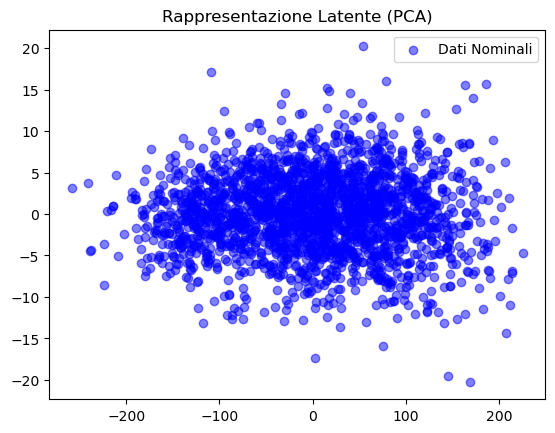

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, Dropout, Add, Cropping2D
from tensorflow.keras.optimizers import Adam

# Residual block per migliorare la capacità di rappresentazione
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = Add()([x, shortcut])
    return x

# Configurazione del modello
latent_dim = 16  # Dimensione dello spazio latente

# Encoder
input_layer = Input(shape=(431, 120, 1))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = residual_block(x, 64)  # Residual block
x = Dropout(0.3)(x)  # Dropout
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = residual_block(x, 32)  # Residual block
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
flattened = Flatten()(x)
latent_space = Dense(latent_dim, activation='relu')(flattened)

# Decoder aggiornato
x = Dense(flattened.shape[1], activation='relu')(latent_space)
x = Reshape((54, 15, 16))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = residual_block(x, 32)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# UpSampling finale con fattore intero
x = UpSampling2D(size=(2, 2))(x)  # Fattore intero
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Usa Cropping2D per correggere la dimensione temporale
x = Cropping2D(cropping=((1, 0), (0, 0)))(x)  # Rimuove 1 riga temporale in eccesso
output_layer = x

autoencoder = Model(input_layer, output_layer)

# Compilazione del modello
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Stampa il sommario del modello
autoencoder.summary()

# Prepara i dati
# Supponiamo che `train_normal_data` sia già preprocessato come array NumPy con forma (num_samples, 431, 120)
train_normal_data_expanded = train_normal_data[..., np.newaxis]  # Aggiungi il canale

# Addestramento
autoencoder.fit(train_normal_data_expanded, train_normal_data_expanded, 
                epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Estrai rappresentazioni latenti
encoder = Model(input_layer, latent_space)
latent_data = encoder.predict(train_normal_data_expanded)

# Visualizza le rappresentazioni latenti
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_data)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.5, label='Dati Nominali')
plt.title('Rappresentazione Latente (PCA)')
plt.legend()
plt.show()


In [14]:
# Salva il modello
autoencoder.save('autoencoder_model.h5')
print("Modello salvato come 'autoencoder_model.h5'")
autoencoder.save('my_model.keras')

Modello salvato come 'autoencoder_model.h5'


In [5]:
import numpy as np
from tensorflow.keras.models import load_model

# Carica il modello salvato
autoencoder = load_model('my_model.keras')
print("Modello caricato con successo!")


def calculate_reconstruction_error(model, data):
    """
    Calcola l'errore di ricostruzione per un dataset.

    Args:
        model: Modello addestrato.
        data (np.ndarray): Dataset da analizzare.

    Returns:
        np.ndarray: Reconstruction error per ogni campione.
    """
    reconstructed = model.predict(data)
    error = np.mean(np.square(data - reconstructed), axis=(1, 2, 3))
    return error

test_normal_data_expanded = test_normal_data[..., np.newaxis]  # Aggiungi il canale
reconstruction_error_normal = calculate_reconstruction_error(autoencoder, test_normal_data_expanded)

# Mostra statistiche del reconstruction error
print("Errore di ricostruzione sui dati nominali:")
print(f"Media: {np.mean(reconstruction_error_normal):.4f}, Deviazione Standard: {np.std(reconstruction_error_normal):.4f}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 30 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Modello caricato con successo!
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step
Errore di ricostruzione sui dati nominali:
Media: 1.0000, Deviazione Standard: 0.0000


In [6]:
anomaly_data_expanded = anomaly_data[..., np.newaxis]  # Aggiungi il canale
reconstruction_error_anomalies = calculate_reconstruction_error(autoencoder, anomaly_data_expanded)

# Mostra statistiche del reconstruction error
print("Errore di ricostruzione sui dati di anomalie:")
print(f"Media: {np.mean(reconstruction_error_anomalies):.4f}, Deviazione Standard: {np.std(reconstruction_error_anomalies):.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step
Errore di ricostruzione sui dati di anomalie:
Media: 1.0000, Deviazione Standard: 0.0000


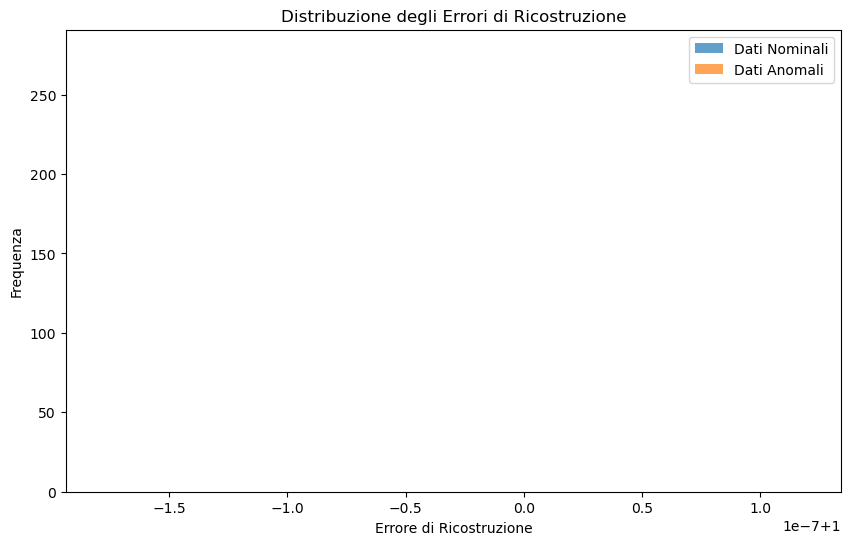

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error_normal, bins=50, alpha=0.7, label='Dati Nominali')
plt.hist(reconstruction_error_anomalies, bins=50, alpha=0.7, label='Dati Anomali')
plt.xlabel('Errore di Ricostruzione')
plt.ylabel('Frequenza')
plt.title('Distribuzione degli Errori di Ricostruzione')
plt.legend()
plt.show()
